<h1 align="center">K-Nearest Neighbors (KNN)</h1>

<br>

This tutorial is based on the book *An Introduction to Statistical Learning*, which is fully accessible online ([link](https://hastie.su.domains/ISLR2/ISLRv2_website.pdf))

<h2 align="center">Theory and Intuition</h2>

- K nearest neighbors is one of the simplest machine learning  algorithms.
- It simply assigns a label to new data based on the **distance** between the old data and new data.
- In KNN classification, the output is a class membership. An object is classified by a plurality vote of its neighbors, with the object being assigned to the class most common among its k nearest neighbors (k is a positive integer, typically small).

<div>
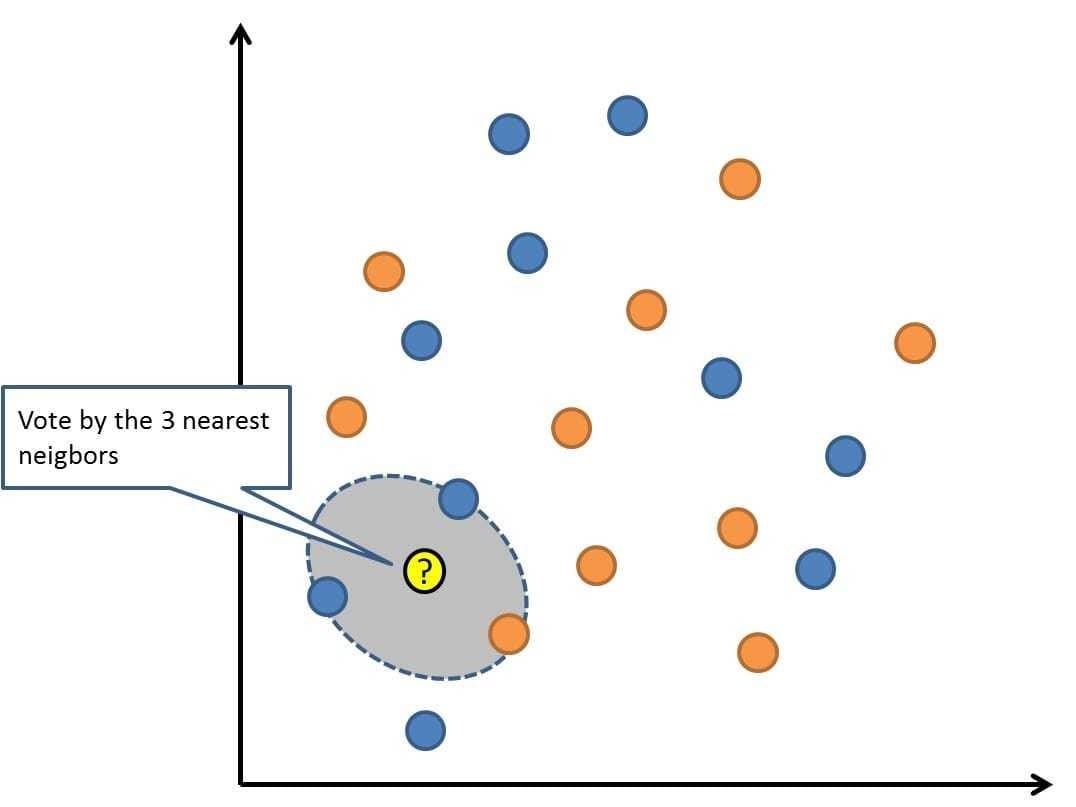
</div>

In this image, the blue and orange dots represent two different classes. The yellow dot with the question mark represents a new data point that needs to be classified by the KNN classification algorithm. When K=3 (like illustrated in the picture), the KNN classification algorithm classifies the new data points as blue, because from three of its nearest neighbors two are blue and one is orange (plurality vote, blue wins). In the case of ties (e.g. if K=4 and two nearest points are blue and two are orange), the new data point is labeled as the class that is closest to it.

So how to choose the optimal K value?
- We want a K value that minimizes the following error:
    - Error = 1 - Accuracy


- The optimal K value can be found by performing a **cross validation** and a **grid search** of multiple K values and choosing K that results in the lowest error (highest accuracy).


- Cross validation, however, only takes into account the K value with the lowest error rate across multiple folds.
    
    $\, \boldsymbol{\rightarrow} \,$ This could result in a more complex model (higher value of K)
    
    
- Consider the context of the problem to decide if larger K values are an issue.

<br>

# KNN with scikit-learn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("C:/Users/testi/Desktop/ML/DATA/gene_expression.csv")

In [3]:
df.head()

,Gene One,Gene Two,Cancer Present
0,4.3,3.9,1
1,2.5,6.3,0
2,5.7,3.9,1
3,6.1,6.2,0
4,7.4,3.4,1


- *Gene One* and *Gene Two* are the features, and *Cancer Present* is the response variable.
- (1 indicates that cancer is present, and 0 indicates that there is no cancer present)

You always want to start by exploring your data set.

In [4]:
df.shape

(3000, 3)

In [5]:
df.dtypes

Gene One          float64
Gene Two          float64
Cancer Present      int64
dtype: object

In [6]:
df["Cancer Present"].value_counts()

1    1500
0    1500
Name: Cancer Present, dtype: int64

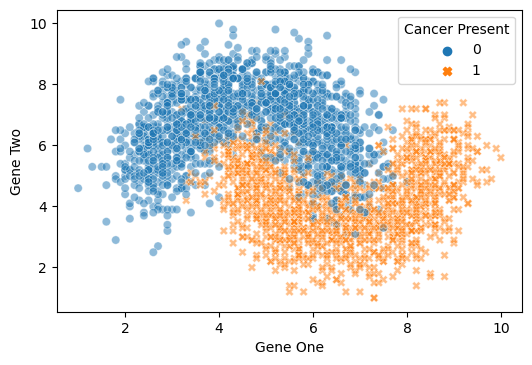

In [7]:
plt.figure(figsize=(6, 4), dpi=100)
sns.scatterplot(x="Gene One", 
                y="Gene Two",
                hue="Cancer Present",
                style="Cancer Present",
                alpha=0.5,
                data=df);

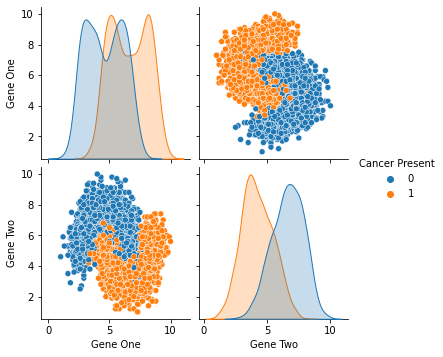

In [8]:
sns.pairplot(data=df, hue="Cancer Present");

<br>

**Preparing the Data and Training the Model**

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [10]:
X = df.drop("Cancer Present", axis=1)
y = df["Cancer Present"]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=42)

In [20]:
# When using the KNN algorithm, you always want to scale your data
scaler = StandardScaler()

In [13]:
# Note that you only fit the scaler to the training data
scaler.fit(X_train)

StandardScaler()

In [14]:
# We scale the feature values (X_train and X_test), but not the label values (y_train and y_test)
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)

Let's first start with the simplest possible model; K=1
- Note that the parameter that we specify the value of K to is called **n_neighbors**

In [15]:
knn_model = KNeighborsClassifier(n_neighbors=1)

In [16]:
knn_model.fit(scaled_X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [17]:
# Make predictions
y_pred = knn_model.predict(scaled_X_test)

In [18]:
# Evaluate performance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

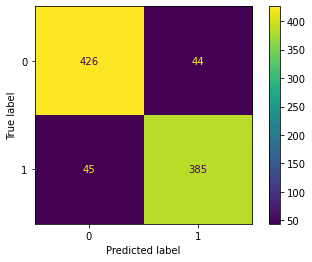

In [19]:
cm = confusion_matrix(y_test, y_pred, labels=knn_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_model.classes_)
disp.plot();

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.91      0.91       470
           1       0.90      0.90      0.90       430

    accuracy                           0.90       900
   macro avg       0.90      0.90      0.90       900
weighted avg       0.90      0.90      0.90       900



We could also perform a for loop and go through a bunch of different k values and choose the model with the smallest error.

In [47]:
from sklearn.metrics import accuracy_score
test_error_rates = []

for k in range(1, 30):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(scaled_X_train, y_train)
    label_pred = model.predict(scaled_X_test)
    test_error = 1 - accuracy_score(y_test, label_pred)
    test_error_rates.append((f"K={k}" ,test_error))

In [54]:
# We want to minimize the error, 
# so we use min() together with lambda function to return the smallest error.
min(test_error_rates, key = lambda x: x[1])

('K=22', 0.05111111111111111)

- The smallest error (1 - Accuracy) was achieved when K=22.

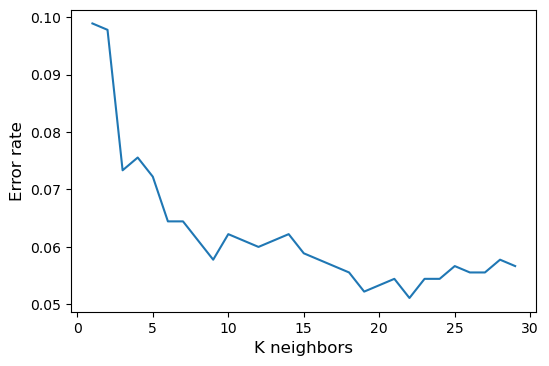

In [63]:
# Plot the errors for a visualization of the behaviour of the error for different K values.
# Note that we have to use a list comprehension to get only the errors from the tuples.
plt.figure(figsize=(6, 4), dpi=100)
plt.plot(range(1, 30), [x[1] for x in test_error_rates])
plt.xlabel("K neighbors", size=12)
plt.ylabel("Error rate", size=12);

- These methods of choosing the K values by hand and testing the performance are called *elbow methods*.
- Usually, however, you want to use cross validation and grid search to find the optimal K value.

<br>

# Finding the Optimal K value with Cross Validation and Grid Search

For this, we're going to use a **Pipeline** object.
- A Pipeline object in scikit-learn can set up a sequence of repeated operations, such as a scaler and a model.
- This way only the pipeline needs to be called, instead of having to repeatedly call a scaler and a model.
- https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

We'll use a **Pipeline** object to set up a workflow of operations:
- Scale data
- Create model on scaled data

When you use the **StandardScaler** as a step inside a **Pipeline**, then scikit-learn will internally do the job for you. 

What happens can be discribed as follows:
- Step 0: The data are split into TRAINING data and TEST data according to the cv parameter that you specified in the GridSearchCV.
- Step 1: the scaler is fitted on the TRAINING data
- Step 2: the scaler transforms TRAINING data
- Step 3: the models are fitted/trained using the transformed TRAINING data
- Step 4: the scaler is used to transform the TEST data
- Step 5: the trained models predict the label values using the transformed TEST data

**Note**: If your parameter grid is going inside a PipeLine, your parameter name needs to be specified in the following manner:
- chosen_string_name + two underscores + parameter key name
- model_name + __ + parameter name
- knn_model + __ + n_neighbors
- knn_model__n_neighbors


- The reason we have to do this is because it let's scikit-learn know what operation in the pipeline these parameters are related to (otherwise it might think n_neighbors was a parameter in the scaler)

    $\, \boldsymbol{\rightarrow} \, $ [StackOverflow on this subject](https://stackoverflow.com/questions/41899132/invalid-parameter-for-sklearn-estimator-pipeline)

In [64]:
scaler = StandardScaler()

In [66]:
knn = KNeighborsClassifier()

In [71]:
# Operations to perform inside the Pipeline.
# Note that these pair of tuples have to be in the exact order that you expect them to happen \
# inside the Pipeline.
# In our case, we first scale the data, then we fit the model,
# that's why they are in this specific order inside the operations list.
operations = [("scaler", scaler), ("knn", knn)]

In [74]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [73]:
pipe = Pipeline(steps=operations)

In [76]:
# Choose the K values to work with
k_values = list(range(1, 20))

- Note that this is not the same thing as running a loop and checking only these individual K values from 1 to 19.
- We are actually performing a cross validation for every single one of these K values.

In [77]:
param_grid = {"knn__n_neighbors": k_values}

In [85]:
full_cv_classifier = GridSearchCV(pipe, 
                                  param_grid, 
                                  cv=5,
                                  scoring="accuracy")

In [134]:
# Note that we don't need to scale the data anymore ourselves, 
# since the scaling step is within the pipeline.
# Therefore, we pass the unscaled TRAINING data inside the fit method.
# Note! To avoid an error message later on when predicting,
# Use the values of the training data, not the whole Pandas DataFrame object.
full_cv_classifier.fit(X_train.values, y_train.values)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19]},
             scoring='accuracy')

In [135]:
# The best estimator
full_cv_classifier.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier(n_neighbors=16))],
 'verbose': False,
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(n_neighbors=16),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 16,
 'knn__p': 2,
 'knn__weights': 'uniform'}

Note that when making predictions using the trained **full_cv_classifier**, it automatically chooses the best model with the optimal K value found during the Grid Search.

In [136]:
final_pred = full_cv_classifier.predict(X_test.values)

In [137]:
print(classification_report(y_test, final_pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       470
           1       0.95      0.93      0.94       430

    accuracy                           0.94       900
   macro avg       0.94      0.94      0.94       900
weighted avg       0.94      0.94      0.94       900



We could also use this model to predict a single patient coming into the hospital.

In [138]:
df.head(1)

,Gene One,Gene Two,Cancer Present
0,4.3,3.9,1


For example, if the new patient had a Gene One score of 3.8, and Gene Two score of 6.4. We could then predict whether or not he or she has cancer.

In [139]:
# Note that the array needs to be 2D
new_patient = [[3.8, 6.4]]

In [142]:
# Predict the class which the new patient belongs to: 0 = no cancer, 1 = cancer present.
full_cv_classifier.predict(new_patient)

array([0], dtype=int64)

In [141]:
# Predict the probability of belonging to a class.
# First value of the array is the probability of belonging to class 0,
# and the second value of the array is the probability of belonging to class 1.
full_cv_classifier.predict_proba(new_patient)

array([[1., 0.]])

- Since our model predicts that the new patient belongs to class 0 with a probability of 1, this means that every neighbor "voted" for class 0 (i.e. every neighbor of this new patient was labeled as class 0).

**NOTE**
- If you didn't use only the values of the training data (instead of the whole Pandas DataFrame) when training the full_cv_classifier like i suggested, you might get an error message here when predicting saying:
    - UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names